In [35]:
# Ramsey King
# DSC 550 - Data Mining
# November 7, 2021
# Exercise 9.3

In [36]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

data = pd.read_json('categorized-comments.jsonl', lines=True)
data.head(1)
data.shape



(606476, 2)

In [37]:
category_list = list(set(data['cat']))
category_list

['sports', 'video_games', 'science_and_technology']

In [38]:
def make_categorical(corpus_cat):
    cat_dictionary = {
        'science_and_technology': 1,
        'sports': 2,
        'video_games': 3,
    }

    return cat_dictionary.get(corpus_cat)

data['cat_num'] = data['cat'].apply(make_categorical)


1. Neural Network Classifier with Scikit

Using the multi-label classifier dataset (categorized-comments.jsonl), fit a neural network classifier using scikit-learn to predict the comment category. Use the code found in chapter 12 of the Applied Text Analysis with Python book as a guide, but you will need to modify the code for this dataset. Report the accuracy, precision, recall, F1-score, and confusion matrix.

In [39]:
stemmer = SnowballStemmer('english')
stop_words = stopwords.words('english')

data['processed_text'] = data['txt'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', " ", x).split() if i not in stop_words]).lower())
data['processed_text'][0]

'bare better gabbert he signific better year he th passer rate ahead guy like philip river carson palmer eli man tyrod taylor and worst surround offens cast leagu he without doubt better career backup list although jimmi g could potenti better riski kaep especi get one cheap year anyway still get rid much acquir'

We will get the scores required to satsify the exercise requirements:

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data['processed_text'], data.cat_num, test_size=0.2)

pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2), stop_words='english', sublinear_tf=True)),
('chi', SelectKBest(chi2, k=10000)),
('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))
])

model = pipeline.fit(X_train, y_train)
predicted_values = model.predict(X_train)

vectorizer = model.named_steps['vect']
chi = model.named_steps['chi']
clf = model.named_steps['clf']

feature_names = vectorizer.get_feature_names_out()
feature_names = [feature_names[i] for i in chi.get_support(indices=True)]
feature_names = np.asarray(feature_names)

target_names = ['1', '2', '3']

print("Top 10 keywords per class: ")
for i, label in enumerate(target_names):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print('%s: %s' % (label, " ".join(feature_names[top10])))



print("accuracy score: " + str(model.score(X_test, y_test)))
print("f1_score: " + str(f1_score(y_train, predicted_values, average='macro')))
print("recall: " + str(recall_score(y_train, predicted_values, average='macro')))
print("precision: " + str(precision_score(y_train, predicted_values, average='macro')))
print(str(confusion_matrix(y_train, predicted_values)))





Top 10 keywords per class: 
1: textra fingerprint linkm nougat snapdragon moto whatsapp bootloop rcs allo
2: futbin lfc msu clemson auburn wl otw sbc klopp cfb
3: joycon lucio dota mmr bungi rubi amethyst wii nintendo mut
accuracy score: 0.8549746075715605
f1_score: 0.7751635000208775
recall: 0.710042687609802
precision: 0.8966584063567055
[[ 11925    154   7952]
 [   109  64546  51886]
 [   890   5750 341968]]


In [41]:
# f1_score
print("f1_score: " + str(f1_score(y_train, predicted_values, average='macro')))

f1_score: 0.7751635000208775


In [42]:
# recall score
print("recall: " + str(recall_score(y_train, predicted_values, average='macro')))


recall: 0.710042687609802


In [43]:
# precision
print("precision: " + str(precision_score(y_train, predicted_values, average='macro')))


precision: 0.8966584063567055


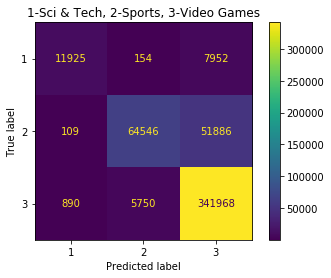

In [49]:
# Confusion Matrix
cm = confusion_matrix(y_train, predicted_values, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title("1-Sci & Tech, 2-Sports, 3-Video Games")
plt.show()